## Setting up: 

In [3]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import datetime

%load_ext autoreload
%autoreload 2

#additional functions: 
from add_functions.proj1_helpers import *
from add_functions.ml_methods_labs import *

### Load Data: 

- train.csv - Training set of 250000 events. The file starts with the ID column, then the label column (the y you have to predict), and finally 30 feature columns.
- test.csv - The test set of around 568238 events - Everything as above, except the label is missing.
- sample-submission.csv - a sample submission file in the correct format. The sample submission always predicts -1, that is ‘background’.

Note: 
- all variables are floating point, except PRI_jet_num which is integer
- variables prefixed with PRI (for PRImitives) are “raw” quantities about the bunch collision as measured by the detector.
- variables prefixed with DER (for DERived) are quantities computed from the primitive features, which were selected by the physicists of ATLAS.
- it can happen that for some entries some variables are meaningless or cannot be computed; in this case, their value is −999.0, which is outside the normal range of all variables.

In [4]:
DATA_TRAIN_PATH = '../data/train.csv' # TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [5]:
print(f'training data shape: y {y.shape}, X {tX.shape}')

training data shape: y (250000,), X (250000, 30)


In [6]:
y[:10], tX[:10,:2]

(array([ 1., -1., -1., -1., -1., -1.,  1.,  1., -1.,  1.]),
 array([[ 138.47 ,   51.655],
        [ 160.937,   68.768],
        [-999.   ,  162.172],
        [ 143.905,   81.417],
        [ 175.864,   16.915],
        [  89.744,   13.55 ],
        [ 148.754,   28.862],
        [ 154.916,   10.418],
        [ 105.594,   50.559],
        [ 128.053,   88.941]]))

In [7]:
### standardize data:  
tX_std = standardize(tX)

#check if standardization method correct: 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(tX)
#print(scaler.transform(tX))

tX_std

array([[ 0.46141372,  0.06833197,  0.40768027, ...,  1.5668    ,
         1.55858439,  0.4125105 ],
       [ 0.51670419,  0.55250482,  0.54013641, ..., -0.63936657,
        -0.63936694, -0.27381996],
       [-2.33785898,  3.19515553,  1.09655998, ..., -0.63936657,
        -0.63936694, -0.29396985],
       ...,
       [ 0.38016991,  0.31931645, -0.13086367, ..., -0.63936657,
        -0.63936694, -0.31701723],
       [ 0.35431502, -0.84532397, -0.30297338, ..., -0.63936657,
        -0.63936694, -0.74543941],
       [-2.33785898,  0.66533608, -0.25352276, ..., -0.63936657,
        -0.63936694, -0.74543941]])

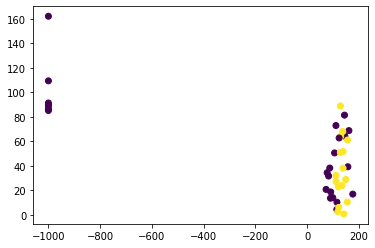

In [8]:
#Plot a few samples of first two coordinates:
NUM_POINTS = 40
plt.scatter(tX[:NUM_POINTS,0], tX[:NUM_POINTS,1], c = y[:NUM_POINTS])

## Implement ML methods:

You should take care of the following:
- Return type: Note that all functions should return: (w, loss), which is the last weight vector of the method, and the corresponding loss value (cost function). Note that while in previous labs you might have kept track of all encountered w for iterative methods, here we only want the last one.
- File names: Please provide all function implementations in a single python file, called implementations.py.
- All code should be easily readable and commented.
- Note that we might automatically call your provided methods and evaluate for correct implementation

### Least Squares GD: 
Linear regression using gradient descent

In [9]:
def gradient_MSE(y, tx, w):
    return (-1/len(y))*tx.T@(y-tx@w)

In [10]:
def MSE_loss(y, tx, w):
    """Calculate the loss.
    You can calculate the loss using mse or mae.
    """
    MSE = np.square(np.subtract(y,tx@w)).mean()
    return MSE

In [12]:
def least_squares_GD(y, tx, initial_w, max_iters, gamma):
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        grad = gradient_MSE(y, tx, w)
        loss = MSE_loss(y, tx, w)
        w -= gamma * grad
        # store w and loss:
        ws.append(w)
        losses.append(loss)
        print("Least squares gradient Descent({bi}/{ti}): loss={l}".format(
            bi=n_iter, ti=max_iters - 1, l=loss))
    return w, losses, losses[-1]

Least squares gradient Descent(0/49): loss=1.0
Least squares gradient Descent(1/49): loss=0.9264755130297607
Least squares gradient Descent(2/49): loss=0.8962466370379263
Least squares gradient Descent(3/49): loss=0.8771600577769225
Least squares gradient Descent(4/49): loss=0.8642270151661157
Least squares gradient Descent(5/49): loss=0.8551458442459038
Least squares gradient Descent(6/49): loss=0.8485355498878915
Least squares gradient Descent(7/49): loss=0.8435390789639571
Least squares gradient Descent(8/49): loss=0.839618166428172
Least squares gradient Descent(9/49): loss=0.8364307895640358
Least squares gradient Descent(10/49): loss=0.8337566792321112
Least squares gradient Descent(11/49): loss=0.8314517631067184
Least squares gradient Descent(12/49): loss=0.8294201370090644
Least squares gradient Descent(13/49): loss=0.8275967020952479
Least squares gradient Descent(14/49): loss=0.825936323685389
Least squares gradient Descent(15/49): loss=0.824407000052939
Least squares gradie

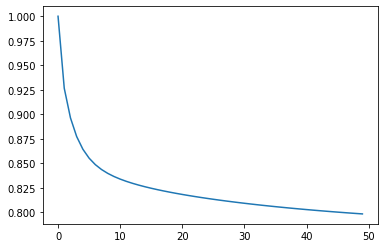

In [13]:
initial_w = np.zeros(tX_std.shape[1])
max_iters = 50
gamma = 0.1
w, losses, final_loss = least_squares_GD(y, tX_std, initial_w, max_iters,
                                         gamma)
plt.plot(losses)

In [14]:
from sklearn.metrics import mean_squared_error
#verify that MSE gives same error as MSE from sklearn:
mean_squared_error(y,tX_std@w), MSE_loss(y, tX_std, w)

(0.7977829151289451, 0.7977829151289451)

### Least Squares SGD:
Linear regression using stochastic gradient descent

In [15]:
def least_squares_SGD(y, tx, initial_w, max_iters, gamma):
    batch_size = 1
    """Stochastic gradient descent algorithm."""
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        for minibatch_y, minibatch_tx in batch_iter(y, tx, batch_size):
            grad = gradient_MSE(minibatch_y, minibatch_tx, w)
            loss = MSE_loss(minibatch_y, minibatch_tx, w)
            w -= gamma * grad
            # store w and loss
            ws.append(w)
            losses.append(loss)
            print("Least squares gradient Descent({bi}/{ti}): loss={l}".format(
                bi=n_iter, ti=max_iters - 1, l=loss))
    return w, losses, losses[-1]

Least squares gradient Descent(0/99): loss=1.0
Least squares gradient Descent(1/99): loss=0.944431814628581
Least squares gradient Descent(2/99): loss=1.103413367165196
Least squares gradient Descent(3/99): loss=1.0139315731383067
Least squares gradient Descent(4/99): loss=0.9918612187343986
Least squares gradient Descent(5/99): loss=0.9549236655706692
Least squares gradient Descent(6/99): loss=0.9309794643477476
Least squares gradient Descent(7/99): loss=0.9194767475382531
Least squares gradient Descent(8/99): loss=0.9983415148899305
Least squares gradient Descent(9/99): loss=1.0193717054750215
Least squares gradient Descent(10/99): loss=0.8887172028579304
Least squares gradient Descent(11/99): loss=0.8746493836276178
Least squares gradient Descent(12/99): loss=1.005013315035412
Least squares gradient Descent(13/99): loss=0.8409821348371556
Least squares gradient Descent(14/99): loss=1.1836539318818724
Least squares gradient Descent(15/99): loss=1.1616893213097188
Least squares gradie

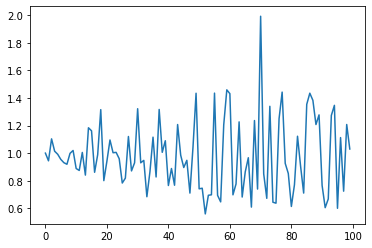

In [27]:
initial_w = np.zeros(tX_std.shape[1])
max_iters = 100
gamma = 0.001
w, losses, final_loss = least_squares_SGD(y, tX_std, initial_w, max_iters,
                                         gamma)
plt.plot(losses)

### Least Squares:
Least squares regression using normal equations. Solve $A^TAx = A^Ty$, Ax = b → x = np.linalg.solve(A, b)

In [24]:
def least_squares(y, tX):
    w = np.linalg.solve(tX.T@tX,tX.T@y)
    loss = MSE_loss(y, tX, w)
    return w, loss

In [25]:
w, loss = least_squares(y, tX_std)
w, loss

(array([ 2.93788277e-02, -2.52531474e-01, -2.54791125e-01, -3.03696826e-02,
        -1.40144781e+00,  2.95701641e-01, -1.07889474e+01,  2.67880862e-01,
        -2.44934951e-03, -3.28854694e+02, -1.82647888e-01,  1.14039627e-01,
         2.05045969e+01,  6.38905957e+01, -3.18961844e-04, -1.80884303e-03,
         6.29996662e+01, -4.48641741e-04,  1.54379312e-03,  1.21462700e-01,
         3.95268515e-04, -6.33223483e-02, -2.06747091e-01, -1.16655759e-01,
         9.86256834e-02,  1.67907660e-01, -3.35146276e-02, -2.98358672e+00,
        -5.36388116e+00,  2.78501929e+02]),
 0.7779046298744752)

### Ridge Regression: 
Ridge regression using normal equations. $w^* = (X^T X+\lambda I)^{-1}X^Ty$

In [32]:
lambda_ = 0.02
def ridge_regression(y, tX, lambda_):
    w = np.linalg.solve(tX.T@tX+lambda_*np.eye(tX.shape[1]),tX.T@y)
    loss = MSE_loss(y, tX, w)
    return w, loss

In [34]:
w, loss = ridge_regression(y, tX_std,lambda_)
w, loss

(array([ 2.93666781e-02, -2.52530497e-01, -2.54823428e-01, -3.02099334e-02,
         8.53966995e-01,  2.92033690e-01, -1.01968078e+01,  2.67887607e-01,
        -2.52731682e-03, -3.50032924e-02, -1.82661485e-01,  1.14032110e-01,
         1.70868417e+01,  1.98775744e-01, -3.51306513e-04, -1.76418914e-03,
         2.94473957e-01, -4.74274957e-04,  1.59561206e-03,  1.21483014e-01,
         4.42749327e-04, -6.32331358e-02, -2.06402058e-01, -1.13409100e-01,
         1.05354901e-01,  1.57890918e-01, -1.44627398e-02, -2.74806187e+00,
        -5.04492362e+00, -4.45555753e-02]),
 0.777912229090242)

### Logistic regression: 
Logistic regression using gradient descent or SGD. 
https://github.com/SSaishruthi/LogisticRegression_Vectorized_Implementation/blob/master/Logistic_Regression.ipynb

In [40]:
def sigmoid_activation(r):
    final_result = 1 / (1 + np.exp(-r))
    return final_result

In [47]:
def model_optimize(w, X, Y):
    m = X.shape[0]

    #Prediction
    final_result = sigmoid_activation(np.dot(w, X.T))
    Y_T = Y.T
    cost = (-1 / m) * (np.sum((Y_T * np.log(final_result)) +
                              ((1 - Y_T) * (np.log(1 - final_result)))))
    #Gradient calculation
    dw = (1 / m) * (np.dot(X.T, (final_result - Y.T).T))
    grads = {"dw": dw}
    return grads, cost

In [63]:
def logistic_regression(Y, X, initial_w, max_iters, gamma):
    losses = []
    for n_iter in range(max_iters):
        #
        grads, loss = model_optimize(initial_w,X,Y)
        #
        dw = grads["dw"]
        #weight update
        w = w - (gamma * (dw.T))
        losses.append(loss)
        print("Logistic regression ({bi}/{ti}): loss={l}".format(
                bi=n_iter, ti=max_iters - 1, l=loss))

    #final parameters
    coeff = {"w": w}
    gradient = {"dw": dw}
    
    return coeff, gradient, losses, losses[-1]

Logistic regression (0/49): loss=0.693147180559945
Logistic regression (1/49): loss=0.6925248331090583
Logistic regression (2/49): loss=0.6919050320835164
Logistic regression (3/49): loss=0.6912877631121825
Logistic regression (4/49): loss=0.690673011895361
Logistic regression (5/49): loss=0.6900607642047352
Logistic regression (6/49): loss=0.6894510058832996
Logistic regression (7/49): loss=0.6888437228452874
Logistic regression (8/49): loss=0.6882389010760898
Logistic regression (9/49): loss=0.6876365266321747
Logistic regression (10/49): loss=0.687036585640994
Logistic regression (11/49): loss=0.6864390643008913
Logistic regression (12/49): loss=0.6858439488810026
Logistic regression (13/49): loss=0.6852512257211503
Logistic regression (14/49): loss=0.6846608812317351
Logistic regression (15/49): loss=0.6840729018936211
Logistic regression (16/49): loss=0.6834872742580173
Logistic regression (17/49): loss=0.6829039849463542
Logistic regression (18/49): loss=0.6823230206501556
Logist

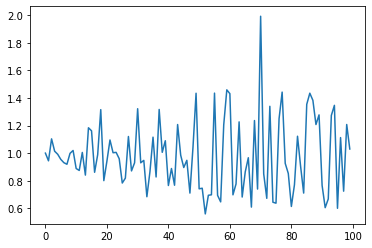

In [64]:
initial_w = np.zeros(tX_std.shape[1])
max_iters = 50
gamma = 0.001
coeff, gradient, costs, final_loss = model_predict(initial_w, tX_std,y, gamma, max_iters)
plt.plot(losses)

### Regularized logistic regression
Regularized logistic regression using gradient descent or SGD

In [ ]:
def reg_logistic_regression(y, tx, lambda_, initial_w, max_iters, gamma):
    """TO DO"""
    raise Exception("Not implemented yet")
    return 0

## Generate predictions and save ouput in csv format for submission:

In [ ]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download test data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)
print(f'test data shape: X {tX_test.shape}')

In [ ]:
"""
OUTPUT_PATH = '' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)
"""